# Table of Contents
- [Dataset Overview](#overview)
- [Preprocessing & Data Cleaning (01)](#preprocessing)
- [Charts & Visualisation (02)](#visualisation)
- [Relationships between features/attributes (2.5)](#interrelationships)
- [Multi-Layer Perceptron (03)](#mlperceptron)
- [LGBM Classifier (04)](#lgbmclassifier)
- [Random Forest (05)](#randomforest)

# Import Statements & read csv

In [2]:
!pip install lightgbm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import warnings
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Additional imports
import sklearn.metrics as metrics

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')



df = pd.read_csv('/kaggle/input/traindataset2/train.csv')

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Overview of Dataset <a id="overview"></a>

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,eat_high_caloric_food,eat_vegetables_frequency,main_meals_day,eat_between_meals,smoke,water_day,monitor_calories,exercise_frequency,device_time,drink_alcohol,transport_mode,obese_category
0,Male,24,1.70,82,yes,yes,2,3,Sometimes,no,3,no,0,1,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18,1.56,57,yes,yes,2,3,Frequently,no,2,no,1,1,no,Automobile,Normal_Weight
2,Female,18,1.71,50,yes,yes,2,1,Sometimes,no,2,no,1,2,no,Public_Transportation,Insufficient_Weight
3,Female,21,1.71,131,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,32,1.91,94,yes,yes,3,2,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Overweight_Level_II


# Dataset Outline
Counting datatype for each feature & non-null values 

In [4]:
df.info(verbose=True, show_counts=True)
print('summary')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  int64  
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  int64  
 4   family_history_with_overweight  20758 non-null  object 
 5   eat_high_caloric_food           20758 non-null  object 
 6   eat_vegetables_frequency        20758 non-null  int64  
 7   main_meals_day                  20758 non-null  int64  
 8   eat_between_meals               20758 non-null  object 
 9   smoke                           20758 non-null  object 
 10  water_day                       20758 non-null  int64  
 11  monitor_calories                20758 non-null  object 
 12  exercise_frequency              

## Preprocessing and Data Cleaning (01) <a id="preprocessing"></a>

Rounds floats to integers if irregular data present.  
In Excel, we renamed Spanish acronymns to English terms.
We handle missing data by imputing missing values with the median.

In [5]:
float_columns = ['Age','Weight', 'eat_vegetables_frequency', 'main_meals_day',
       'water_day', 'exercise_frequency', 'device_time']  

numerical_columns = ['Age', 'Height','Weight','eat_vegetables_frequency','main_meals_day','water_day','exercise_frequency','device_time']

# Handle missing data by imputing missing values with median
median_imputer = df[numerical_columns].median()
df[numerical_columns] = df[numerical_columns].fillna(median_imputer)

In [6]:
print('\nTrain Set Rows:',df.shape[0])
# Identify duplicate rows
duplicate_rows = df[df.duplicated()]

print("Some duplicate rows:")
print(duplicate_rows.head())

df.drop_duplicates(inplace=True)

print('\nTrain Set Rows:',df.shape[0])


Train Set Rows: 20758
Some duplicate rows:
     Gender  Age  Height  Weight family_history_with_overweight  \
62   Female   26    1.61     112                            yes   
86   Female   26    1.64     112                            yes   
88   Female   26    1.64     112                            yes   
98   Female   26    1.64     111                            yes   
158  Female   26    1.64     112                            yes   

    eat_high_caloric_food  eat_vegetables_frequency  main_meals_day  \
62                    yes                         3               3   
86                    yes                         3               3   
88                    yes                         3               3   
98                    yes                         3               3   
158                   yes                         3               3   

    eat_between_meals smoke  water_day monitor_calories  exercise_frequency  \
62          Sometimes    no          3         

In [7]:
print('Rows:',df.shape[0]) 


import numpy as np

# Remove outliers using z-score
def remove_outliers_zscore(df, threshold=3):
    
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    
    for col in numeric_cols:
        # Calculate z-scores
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        
        # Identify outliers based on threshold
        outliers = df[z_scores > threshold]
        
        # Remove outliers
        df = df.drop(outliers.index)
    
    return df

print('\nTrain Set Rows:', df.shape[0])

df = remove_outliers_zscore(df)

print('\n X Train Set Rows after outlier removal:', df.shape[0])


Rows: 17316

Train Set Rows: 17316

 X Train Set Rows after outlier removal: 17106


Round floats to ints

In [8]:
float_columns = ['Age','Weight', 'eat_vegetables_frequency', 'main_meals_day',
       'water_day', 'exercise_frequency', 'device_time']  
df[float_columns] = df[float_columns].round().astype(int)


duplicate_count = len(df[df.duplicated()])
print("Number of duplicate rows after preprocessing:", duplicate_count)

Number of duplicate rows after preprocessing: 0


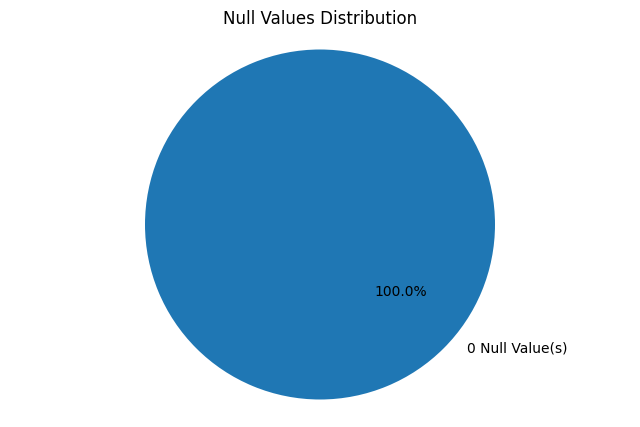

In [9]:
import matplotlib.pyplot as plt


null_counts = df.isnull().sum(axis=1).value_counts()
labels = [f"{count} Null Value(s)" for count in null_counts.index]
counts = null_counts.values

plt.figure(figsize=(8, 5))  
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Null Values Distribution")
plt.axis('equal') 
plt.show()


## Data Visualisation / Charts (02) <a id="visualisation"></a>

In [10]:
print('Original Rows:',df.shape[0])
print('Original Columns:',df.shape[1])
X = df.drop(columns=['obese_category'])  # 'obesity_level' is our target variable
y = df['obese_category']

# Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#check shape of data without obese category
print('\nX Train Set Rows:',X_train.shape[0])
print('X Train Set Columns:',X_train.shape[1])

Original Rows: 17106
Original Columns: 17

X Train Set Rows: 13684
X Train Set Columns: 16


In [11]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'eat_high_caloric_food', 'eat_vegetables_frequency', 'main_meals_day',
       'eat_between_meals', 'smoke', 'water_day', 'monitor_calories',
       'exercise_frequency', 'device_time', 'drink_alcohol', 'transport_mode',
       'obese_category'],
      dtype='object')

In [12]:
def pieCharter(x):
    
    x_count = df[x].value_counts()
    plt.figure(figsize=(8, 6))

    plt.pie(x_count, labels=x_count.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of ' + x)
    plt.axis('equal') 
    plt.show()
    print('Chart maker function')


**Visualisation of Height Feature**

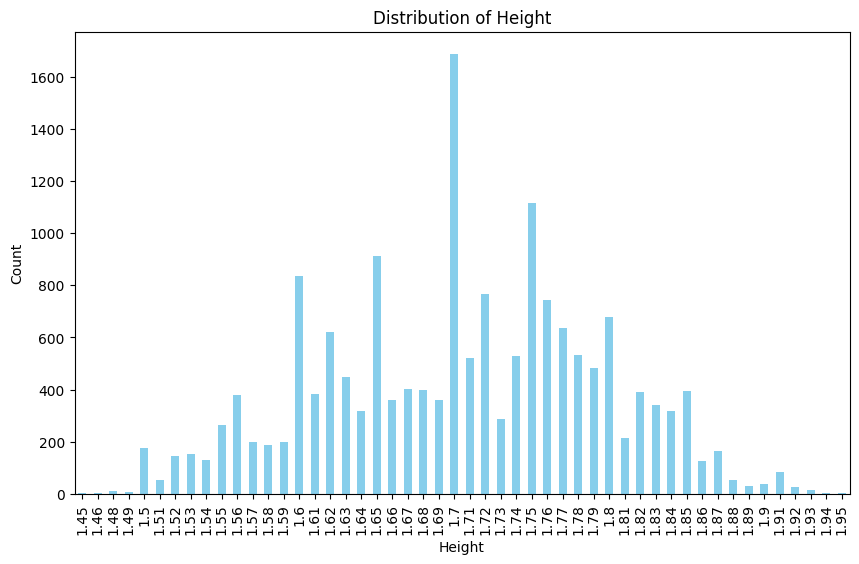

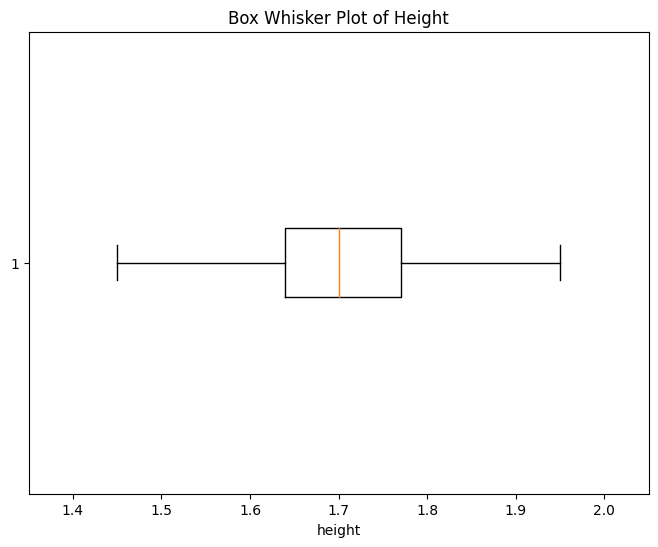

Height Box Plot


In [13]:
#height
plt.figure(figsize=(10, 6))
df['Height'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Height')
plt.xlabel('Height')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['Height'], vert=False)
plt.title('Box Whisker Plot of Height')
plt.xlabel('height')

plt.xlim(left=df['Height'].min()-0.1, right=df['Height'].max() +0.1)
plt.show()
print('Height Box Plot')


**Boxplot**
Weight increases as level of obesity classification increases.

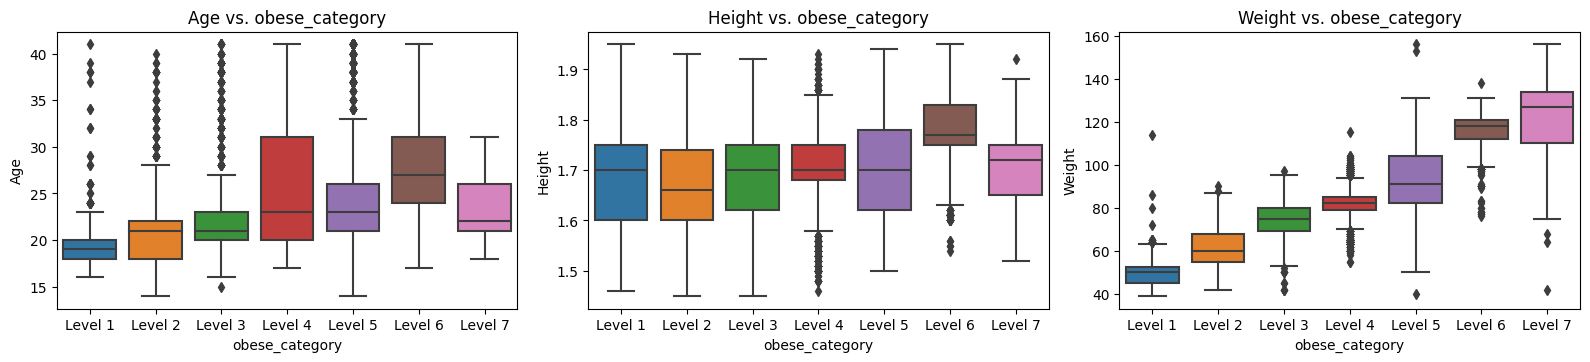

Box Plot


In [14]:
col = ['Age', 'Height', 'Weight']  
category_mapping = {
    'Insufficient_Weight': 'Level 1',
    'Normal_Weight': 'Level 2',
    'Overweight_Level_I': 'Level 3',
    'Overweight_Level_II': 'Level 4',
    'Obesity_Type_I': 'Level 5',
    'Obesity_Type_II': 'Level 6',
    'Obesity_Type_III': 'Level 7'
}

df['obese_category'] = df['obese_category'].replace(category_mapping)
category_order = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 6', 'Level 7']

plt.figure(figsize=(16, 10))
for i, col in enumerate(col, start=1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='obese_category', y=col, data=df, order=category_order)
    plt.title(f'{col} vs. obese_category')
    plt.xlabel('obese_category')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

print('Box Plot')


**Visualisation of Age Feature**

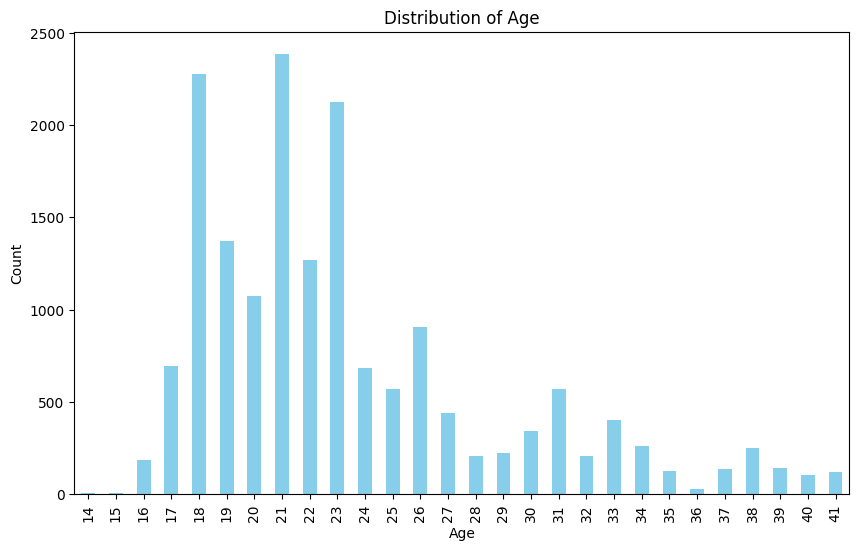

In [15]:
plt.figure(figsize=(10, 6))
df['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

**Visualisation of Weight Feature**

Histogram Plot


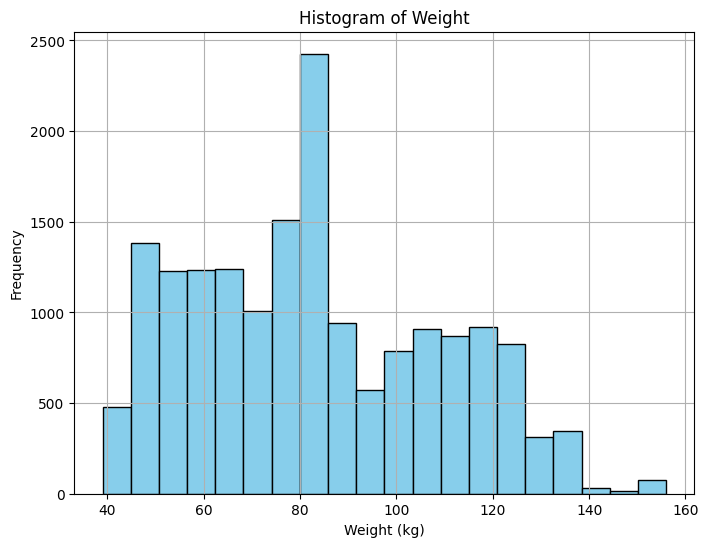

In [16]:
print('Histogram Plot')

#histogram of weight
# Assuming 'weight' is a column in your DataFrame named 'df'
plt.figure(figsize=(8, 6))
plt.hist(df['Weight'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Weight')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**Gender Distribution**

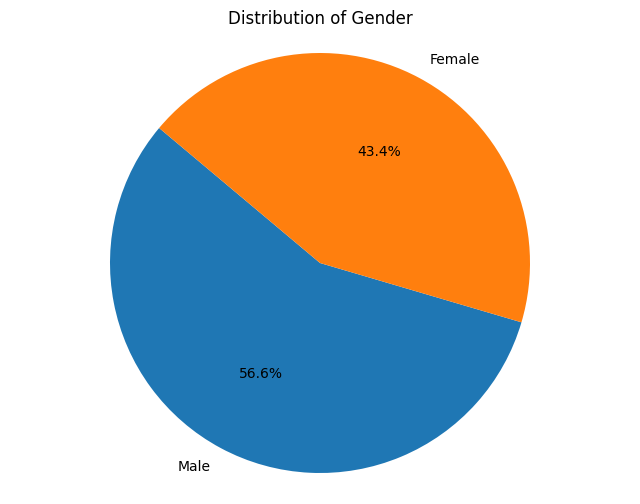

Chart maker function


In [17]:
pieCharter('Gender')

**Visualisation of Family Obesity History**

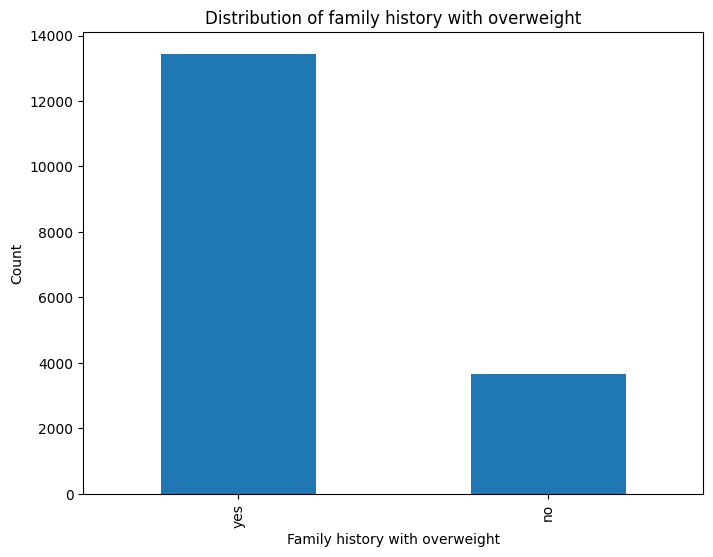

In [18]:
gender_count = df['family_history_with_overweight'].value_counts()

plt.figure(figsize = (8,6))

gender_count.plot(kind='bar')
plt.title('Distribution of family history with overweight')
plt.xlabel('Family history with overweight')
plt.ylabel('Count')
plt.show()

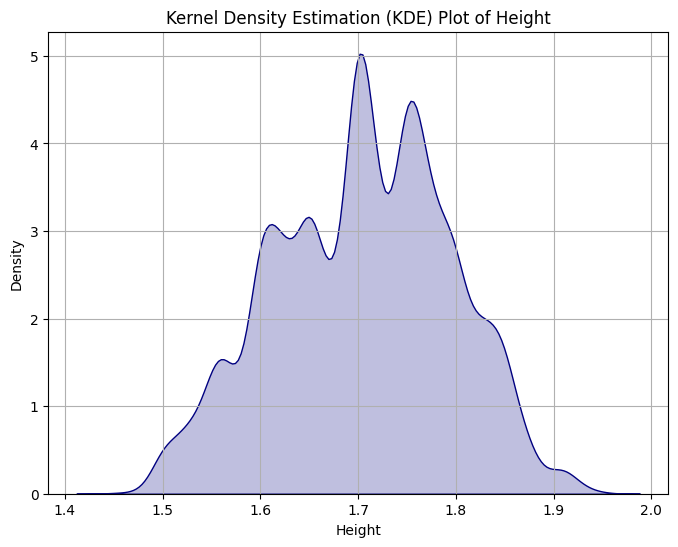

In [19]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df['Height'], fill=True, color='navy')
plt.title('Kernel Density Estimation (KDE) Plot of Height')
plt.xlabel('Height')
plt.ylabel('Density')
plt.grid(True)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

plt.show()


# Relationships between features/attributes (2.5) <a id="interrelationships"></a>

**Cross Chart on Transport Mode and Weight interrelationship**
Obesity_Type II or Type III people either seldom or don't walk or cycle, indicating a lack of physical activity.


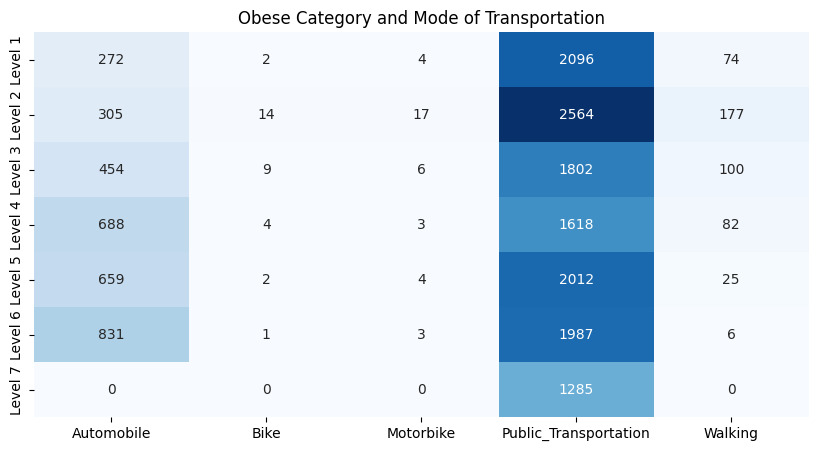

In [20]:
#why no obesityIII drive automobile?
cross_tab = pd.crosstab(df['obese_category'], df['transport_mode'])
plt.figure(figsize=(10, 5))
plt.rcParams['font.family'] = 'Arial'
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Obese Category and Mode of Transportation')
plt.xlabel('')
plt.ylabel('')
plt.show()

**Subquestion: Does Age affect Obese Category?**  Bar Chart & Violin Plot.  Our results indicate that the age profile for individuals with insufficient or normal weight skews younger.


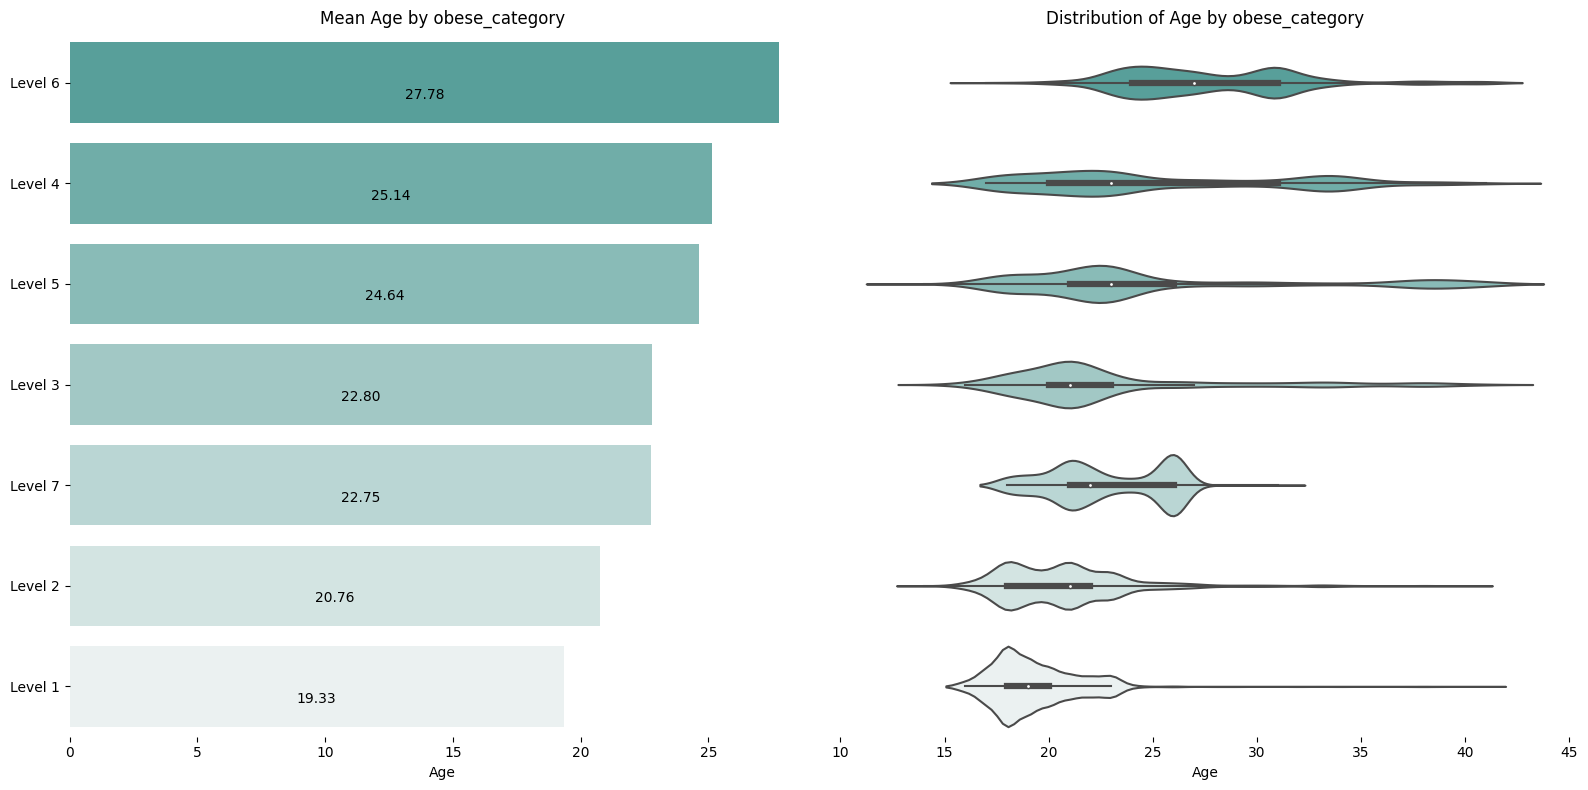

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = axes[0]
df_sort = df.groupby('obese_category')['Age'].mean().sort_values(ascending=False).index
sns.barplot(x='Age', y='obese_category', data=df, palette='light:#4caba4_r', order=df_sort,
            estimator=np.mean, errorbar=None, errwidth=0, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
ax1.set_title('Mean Age by obese_category')
ax1.set_xlabel('Age')
ax1.set_ylabel('')
sns.despine(left=True, bottom=True, ax=ax1)

# Violin Plot
ax2 = axes[1]
sns.violinplot(x='Age', y='obese_category', data=df, palette='light:#4caba4_r', order=df_sort, ax=ax2)
ax2.set_title('Distribution of Age by obese_category')
ax2.set_ylabel("")
plt.yticks([])
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
plt.show()


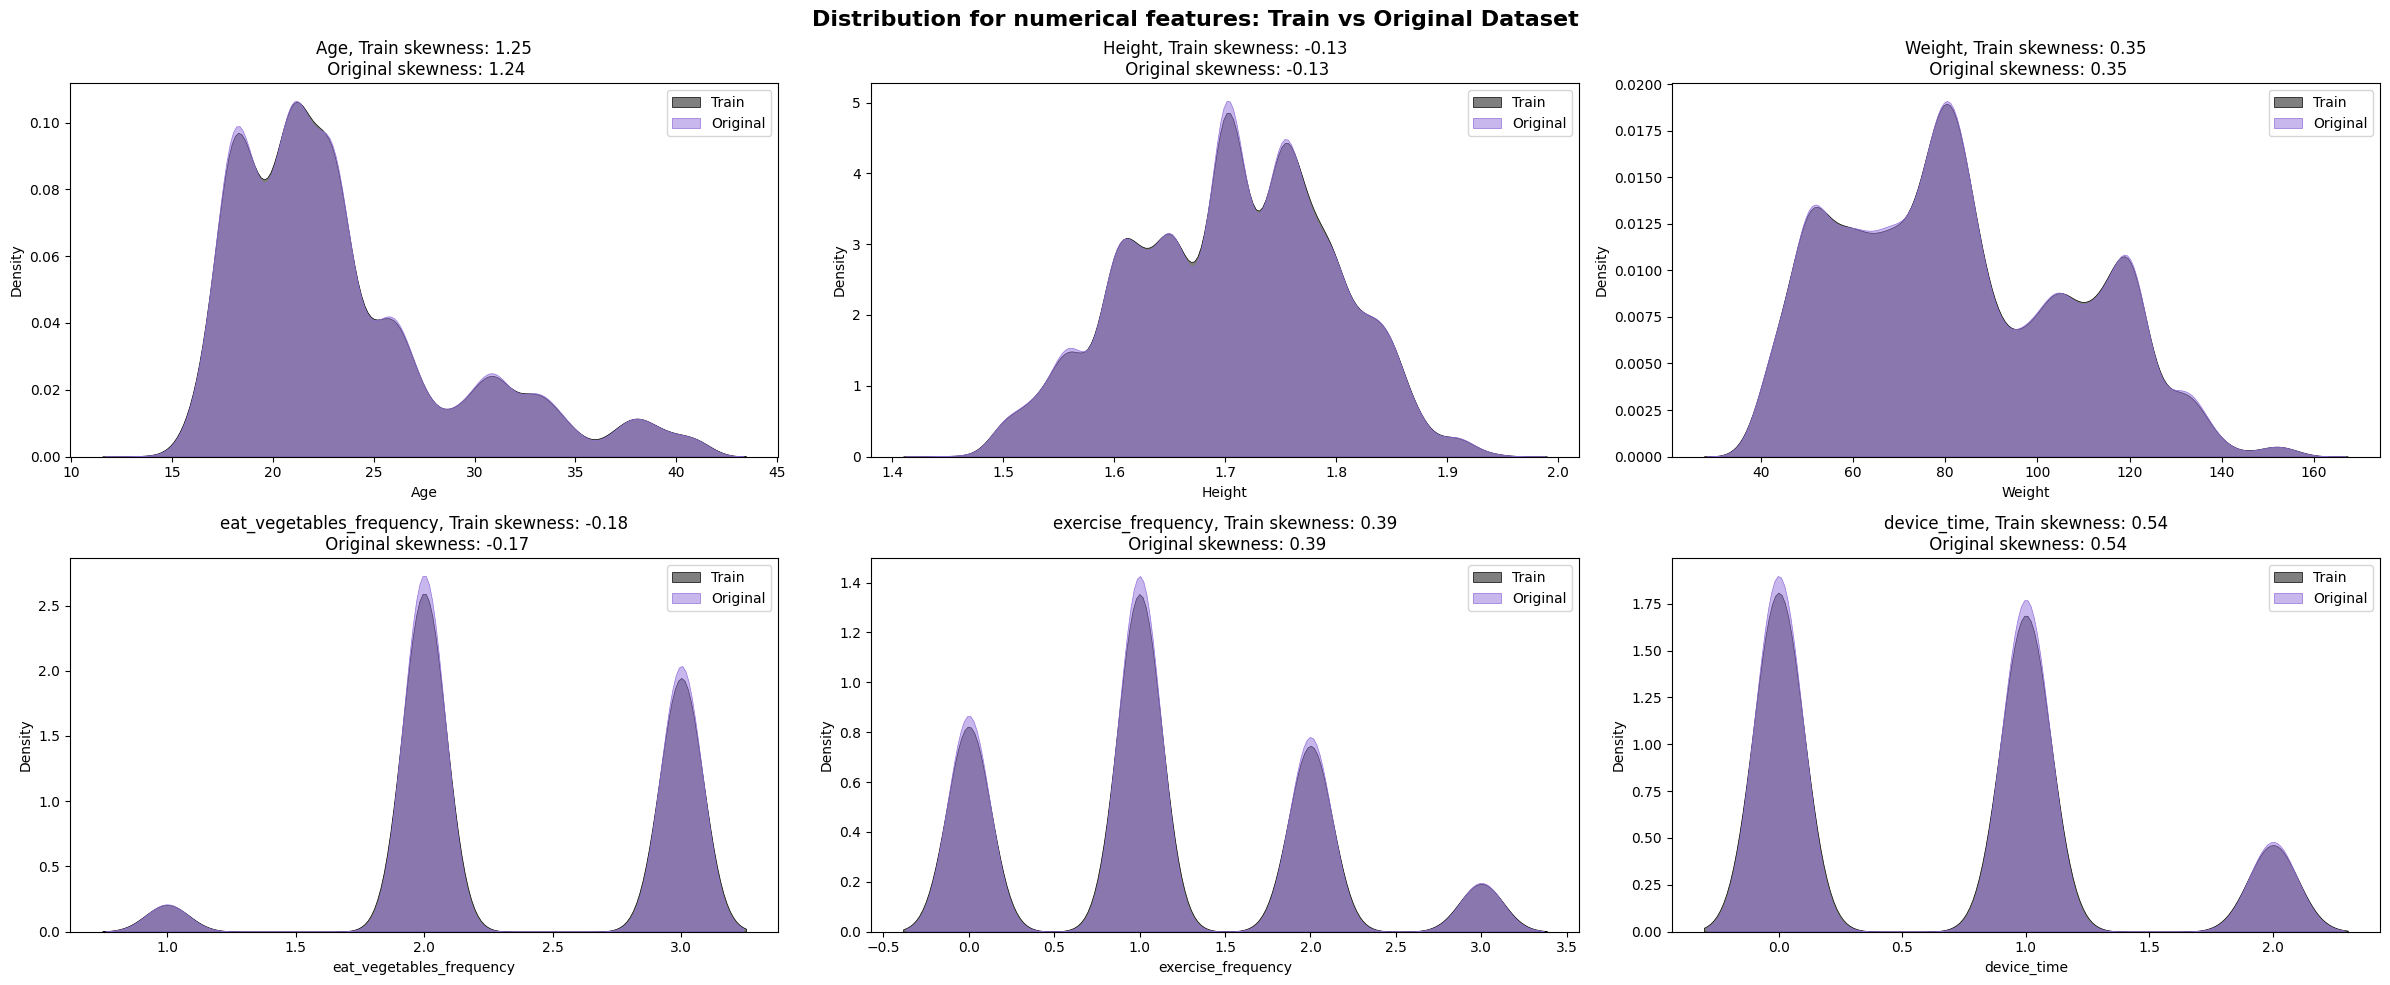

In [22]:
#Kernel Density Estimation (KDE) plots
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
kde_columns = X_train[['Age','Height','Weight','eat_vegetables_frequency','exercise_frequency','device_time']]

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'Montserrat'
plt.rcParams['text.color'] = 'black'
    
def dist(train_dataset, original_dataset, columns_list, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(24, 10))
    plt.suptitle('Distribution for numerical features: Train vs Original Dataset', fontsize=16, fontweight='bold')
    axs = axs.flatten()
    
    for i, col in enumerate(columns_list):
        sns.kdeplot(train_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#000000', label='Train')  
        sns.kdeplot(original_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#9370db', label='Original')
        axs[i].set_title(f'{col}, Train skewness: {train_dataset[col].skew():.2f}\n Original skewness: {original_dataset[col].skew():.2f}')
        axs[i].legend()
        
    plt.tight_layout()
    
dist(train_dataset=X_train, original_dataset=df, columns_list=kde_columns.columns, rows=2, cols=3)

Age, Height and Weight are normally distributed with some skewness.

Obesity Type II is most common among Males, while Obesity Type III is most common among Females.

In [23]:
#function to plot pie charts used below
def showplot(columnname):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['font.family'] = 'Montserrat'
    plt.rcParams['text.color'] = 'black'
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = df[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors = ["#2f042e", "#d668f4", "#c136ff", "#a826db", "#9614b5", "#810090", "#6b0066"]
    
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)
    
    sns.countplot(data=df, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 5, i, str(v), color='black', fontsize=10, ha='left', va='center')  # Adjusted text position    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9, color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold', x=0.44)  # Center the title
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

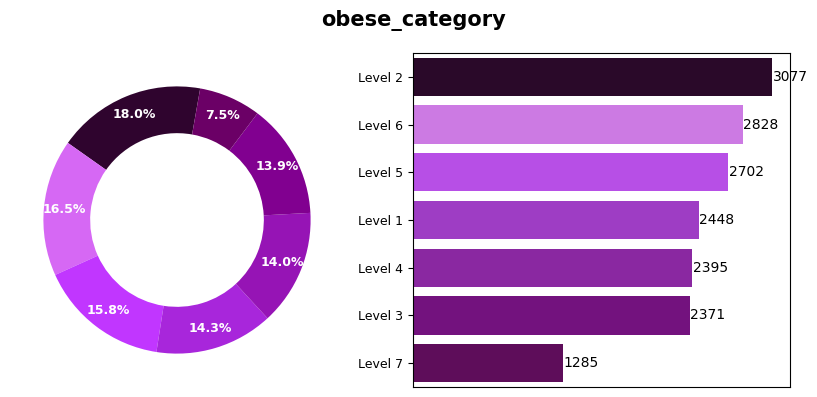

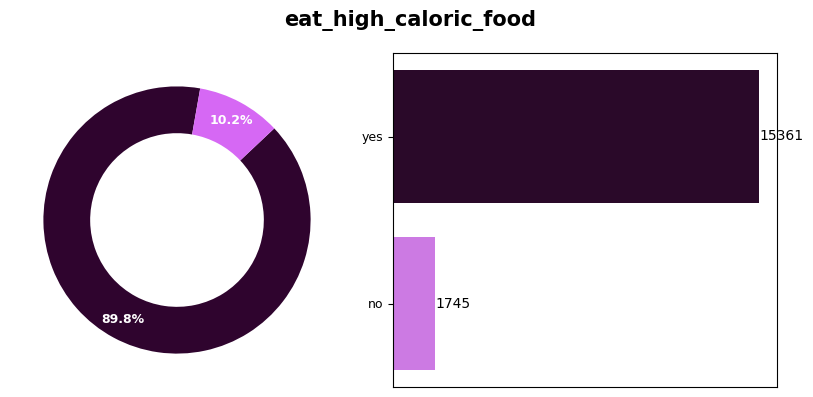

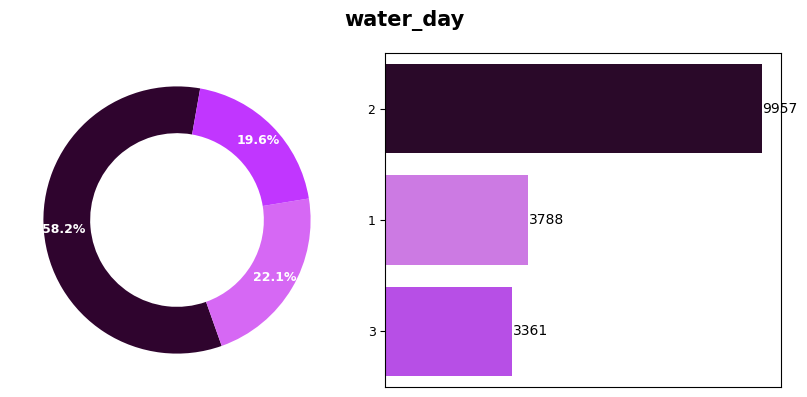

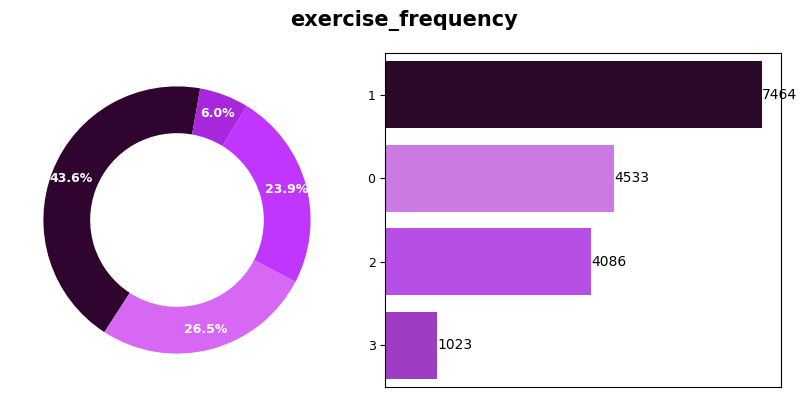

In [24]:
columns = ['obese_category', 'eat_high_caloric_food', 'water_day',
       'exercise_frequency']

for col in columns:
    print(' ')
    showplot(col)


# Multi-Layer Perceptron ML Model (03) <a id="mlperceptron"></a>
MLP is an artificial neural network with nodes with each layer receiving input from the previous layer and passing its output to the next layer.

Backpropagation adjusts the weights of connections between neurons to minimize the difference between the predicted and actual values.

In [ ]:
#MULTI LAYER PERCEPTRON 
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
data = pd.read_csv("/kaggle/input/traindataset2/train.csv")

desired_columns = ['Height', 'Weight', 'eat_vegetables_frequency', 'exercise_frequency','water_day','Age','device_time', 'Gender',
                   'family_history_with_overweight', 'eat_high_caloric_food', 'eat_between_meals', 'smoke', 'monitor_calories', 'transport_mode']
data = data[desired_columns + ['obese_category']]  

#  label encoding for 'obese_category'
label_encoder = LabelEncoder()
data['obese_category'] = label_encoder.fit_transform(data['obese_category'])

tr_features = data.drop(columns=['obese_category'])  
tr_labels = data['obese_category']  

#  columns to one-hot encode
nominal_columns = ['Gender', 'family_history_with_overweight', 'eat_high_caloric_food', 
                   'eat_between_meals', 'smoke', 'monitor_calories', 'transport_mode']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), tr_features.select_dtypes(include=['int', 'float']).columns),  
        ('onehot', OneHotEncoder(), nominal_columns)
    ],
    remainder='passthrough'
)

# the MLP model
mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier())
])


parameters = {
    'classifier__hidden_layer_sizes': [(5,), (10,), (20,)],
    'classifier__activation': ['identity', 'logistic','tanh'],
    'classifier__learning_rate': ['adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01,0.1],  
    'classifier__max_iter': [1000],
    'classifier__solver': ['adam','sgd','lbfgs']  
}

# grid search
cv = GridSearchCV(mlp, parameters, cv=5)
cv.fit(tr_features, tr_labels)


def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    
    mean = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(mean, stds, results.cv_results_['params']):
        print('{} (+/- {}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

print_results(cv)



# LGBM Classifier (04) <a id="lgbmclassifier"></a>

In [ ]:
# Split features and target variable
X = df.drop(columns=['obese_category'])
y = df['obese_category']

# Apply label encoding to the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Apply one-hot encoding to categorical features if needed
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize LGBM classifier with the best parameters
best_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",  
    "verbosity": -1,
    "boosting_type": "gbdt",    
    "random_state": 42,
    "num_class": 7,
    'learning_rate': 0.04,
    'n_estimators': 500,
    'lambda_l1': 0.01,          #lambda_l1 is L1 regularization
    'lambda_l2': 0.04,          #lambda_l2 is L2 regularization
    'max_depth': 10,
    'colsample_bytree': 0.41,   #colsample_bytree is the subsample ratio of columns when constructing each tree
    'subsample': 0.95,          #subsample is the subsample ratio of the training instance
    'min_child_samples': 26     #min_child_samples is the minimum number of data needed in a child (leaf)
}

lgb_classifier = lgb.LGBMClassifier(**best_params)



In [ ]:
# Train LGBM classifier with best parameters
lgb_classifier_best = lgb.LGBMClassifier(**best_params)
lgb_classifier_best.fit(X_train, y_train)

# Predictions on the test set
y_pred = lgb_classifier_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance analysis
feature_importance = lgb_classifier_best.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Get feature names
feature_names = lgb_classifier_best.booster_.feature_name()

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=X_encoded.columns[sorted_idx], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

# Random Forest (05) <a id="randomforest"></a>


In [ ]:
warnings.filterwarnings("ignore")

duplicate_rows = df[df.duplicated()]

# Print out some of the duplicate rows
print("Some duplicate rows:")
print(duplicate_rows.head())

# Drop duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

In [ ]:
X = df.drop(columns=['obese_category'])
y = df['obese_category']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Label encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Calculate BMI and add it as a feature
X_encoded['BMI'] = X_encoded['Weight'] / (X_encoded['Height'] ** 2)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=12)
# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=11)

print(X_train.shape)
print(X_test.shape)

In [ ]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [ ]:
# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters found during grid search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

In [ ]:
# Train RandomForestClassifier with best parameters
rf_classifier_best = RandomForestClassifier(**best_params, random_state=12)
rf_classifier_best.fit(X_train, y_train)

In [ ]:
# Predictions on the test set
y_pred = rf_classifier_best.predict(X_test)

In [ ]:
# Convert NumPy arrays to pandas Series
y_test_series = pd.Series(y_test)
y_pred_series = pd.Series(y_pred)

# Concatenate y_test_series and y_pred_series horizontally
comparison_df = pd.concat([y_test_series, y_pred_series], axis=1)
comparison_df.columns = ['y_test', 'y_pred']

print(comparison_df)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred)) 